In [1]:
# pip install imblearn

In [2]:
# Import Libraries
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import json
import panel as pn
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
pn.extension('plotly')
import plotly.express as px
import seaborn as sns
import nltk

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\jesus\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
load_dotenv()

True

In [4]:
api_key = os.getenv("GLASSNODE_API")
type(api_key)

str

In [5]:
# Define crypto currencies to pull
crypto_list = ["BTC"]

In [6]:
# Define Price URLs
price_url = 'https://api.glassnode.com/v1/metrics/market/price_usd'

In [7]:
# BTC Price API Request
btc_price_res = requests.get(price_url,
                      params={'a': 'BTC',
                              'i': '24h',
                              'api_key': api_key})


# Convert price to Pandas Dataframe, set index to time and clean up file
btc_price_df = pd.read_json(btc_price_res.text, convert_dates=['t'])
btc_price_df.columns = ['Date', 'BTC Price']
btc_price_df.set_index('Date', inplace=True)

In [8]:
# ETH Price API Request
eth_price_res = requests.get(price_url,
                      params={'a': 'ETH',
                              'i': '24h',
                              'api_key': api_key})


# Convert price to Pandas Dataframe, set index to time and clean up file
eth_price_df = pd.read_json(eth_price_res.text, convert_dates=['t'])
eth_price_df.columns = ['Date', 'ETH Price']
eth_price_df.set_index('Date', inplace=True)

In [9]:
# Dogecoin Price from CSV
doge_data_df = pd.read_csv('Plots/DOGE-USD.csv')
doge_price_df = doge_data_df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
doge_price_df.rename(columns={"Close":"Doge Price"}, inplace=True)
doge_price_df.set_index('Date', inplace=True)
# doge_price_df

## ETH Data Table Debugging

In [10]:
eth_price_df.tail()

,ETH Price
Date,
2021-05-07,3487.489826
2021-05-08,3903.095492
2021-05-09,3932.359246
2021-05-10,3954.032924
2021-05-11,4127.318812


In [11]:
# Daily change in price column
eth_daily_price_pct_change = eth_price_df.pct_change(1)
eth_daily_price_pct_change.columns = ['ETH Daily Price Change %']
eth_daily_price_pct_change = eth_daily_price_pct_change.dropna()
eth_daily_price_pct_change.tail()

,ETH Daily Price Change %
Date,
2021-05-07,-0.002239
2021-05-08,0.119170
2021-05-09,0.007498
2021-05-10,0.005512
2021-05-11,0.043825


In [12]:
# Define all the different data frames into a list
eth_frames = [eth_price_df, eth_daily_price_pct_change]

# Concatenate all the dataframes into one
eth_data = pd.concat(eth_frames, axis=1, join="outer", ignore_index=False)
eth_data['ETH Daily Price Change %'] = eth_data['ETH Daily Price Change %']*100
eth_data.tail()

,ETH Price,ETH Daily Price Change %
Date,,
2021-05-07,3487.489826,-0.223941
2021-05-08,3903.095492,11.917043
2021-05-09,3932.359246,0.749758
2021-05-10,3954.032924,0.551162
2021-05-11,4127.318812,4.382510


## Get news

In [13]:
#Ethereum news from CSV
ethereum_df = pd.read_csv(Path('Plots/DataNews_Ethereum.csv'))
ethereum_df['Published Date'] = pd.to_datetime(ethereum_df['Published Date'], exact = False, infer_datetime_format=True, format = '%Y/%m%d')
for i in ethereum_df.index:
     ethereum_df['Published Date'][i] = ethereum_df['Published Date'][i].date()
ethereum_df.columns = ['Date', 'Title', 'Content']

# Ethereum Analysis

## VADER Sentiment Analysis

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Create function to store the sentiment scores in DataFrame
eth_sentiments = []


for i in ethereum_df.index:
    try:
        text = ethereum_df["Content"][i]
        date = ethereum_df["Date"][i]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
    
        
        eth_sentiments.append({
            "text": text,
            "Date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
        })
        
    except AttributeError:
        pass

    
    
# Create DataFrame
eth_df = pd.DataFrame(eth_sentiments)

# Reorder DataFrame columns
cols = ["Date", "text", "compound", "positive", "negative", "neutral"]
eth_df = eth_df[cols]

eth_df.head()

,Date,text,compound,positive,negative,neutral
0,2016-05-25,The scripting language in bitcoin is restricti...,-0.3818,0.000,0.066,0.934
1,2016-05-27,Leading bitcoin hardware mining producer Bitma...,0.0000,0.000,0.000,1.000
2,2016-06-08,Editor’s note: The quote “It is not possible t...,0.0000,0.000,0.000,1.000
3,2016-06-18,A Twitter post from someone claiming to be the...,0.7632,0.216,0.104,0.681
4,2016-06-18,Following the publication of an alleged statem...,-0.7184,0.048,0.149,0.803


In [16]:
# Get descriptive stats from the DataFrame
eth_df.describe()

,compound,positive,negative,neutral
count,3180.000000,3180.000000,3180.000000,3180.000000
mean,0.226278,0.075744,0.030373,0.893883
std,0.424731,0.065838,0.047066,0.075499
min,-0.941300,0.000000,0.000000,0.587000
25%,0.000000,0.000000,0.000000,0.845000
50%,0.273200,0.064000,0.000000,0.899000
75%,0.571900,0.116250,0.053000,0.948000
max,0.957100,0.336000,0.337000,1.000000


In [17]:
# set Date column to index
eth_df['Date'] = pd.to_datetime(eth_df['Date'])
eth_df = eth_df.set_index('Date')

In [18]:
eth_merged = pd.merge(
    eth_df,
    eth_data,
    how='inner',
    on='Date')

eth_merged.dropna()
eth_merged.tail(20)

,text,compound,positive,negative,neutral,ETH Price,ETH Daily Price Change %
Date,,,,,,,
2021-05-07,Ethereum price Today – Can Pancake Swap Eclips...,0.6908,0.130,0.000,0.870,3487.489826,-0.223941
2021-05-07,"Megan Kaspar, Magnetic Managing Director and C...",0.2023,0.083,0.000,0.917,3487.489826,-0.223941
2021-05-07,"Megan Kaspar, Magnetic Managing Director and C...",0.2023,0.083,0.000,0.917,3487.489826,-0.223941
2021-05-07,"Ethereum’s rally halted at $3,600 and declinin...",-0.5499,0.000,0.115,0.885,3487.489826,-0.223941
2021-05-07,\n• Ethereum Classic’s hash rate has hit an al...,0.1280,0.032,0.000,0.968,3487.489826,-0.223941
2021-05-07,It was the so-called ‘Ethereum killers’ day to...,0.4215,0.062,0.000,0.938,3487.489826,-0.223941
2021-05-07,NEW YORK — Ethereum has outperformed major dig...,-0.2500,0.028,0.052,0.920,3487.489826,-0.223941
2021-05-07,Ethereum has outperformed major digital curren...,-0.2500,0.028,0.052,0.920,3487.489826,-0.223941
2021-05-07,"NEW YORK, May 7 (Reuters) - Ethereum has outpe...",-0.2500,0.029,0.053,0.918,3487.489826,-0.223941


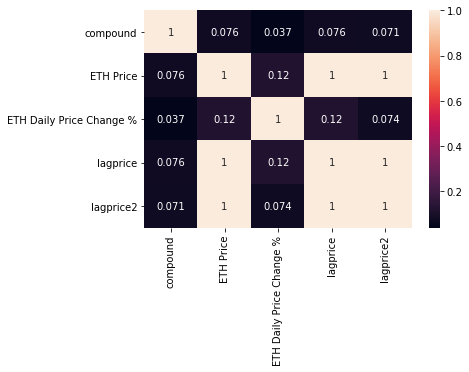

In [19]:
#set mulitple daily observations to a single mean
eth_viz_d = eth_merged.groupby(pd.Grouper(freq='d')).mean().dropna(how='all')
eth_viz_text = pd.DataFrame(eth_merged['text'].groupby('Date').apply(lambda texts: ' '.join(texts)))

eth_viz_w = eth_merged.groupby(pd.Grouper(freq='w')).mean().dropna(how='all')
eth_viz_m = eth_merged.groupby(pd.Grouper(freq='m')).mean().dropna(how='all')
eth_viz_y = eth_merged.groupby(pd.Grouper(freq='y')).mean().dropna(how='all')

eth_corr_d = eth_viz_d.drop(columns=['positive','negative','neutral'])
eth_corr_w = eth_viz_w.drop(columns=['positive','negative','neutral'])
eth_corr_m = eth_viz_m.drop(columns=['positive','negative','neutral'])
eth_corr_y = eth_viz_y.drop(columns=['positive','negative','neutral'])

eth_corr_d['lagprice'] = eth_corr_d['ETH Price'].shift(0)
eth_corr_d['lagprice2'] = eth_corr_d['ETH Price'].shift(1)

eth_corr_w['lagprice'] = eth_corr_w['ETH Price'].shift(0)
eth_corr_w['lagprice2'] = eth_corr_w['ETH Price'].shift(1)

eth_corr_m['lagprice'] = eth_corr_m['ETH Price'].shift(0)
eth_corr_m['lagprice2'] = eth_corr_m['ETH Price'].shift(1)

eth_corr_y['lagprice'] = eth_corr_y['ETH Price'].shift(0)
eth_corr_y['lagprice2'] = eth_corr_y['ETH Price'].shift(1)

eth_heat_d = sns.heatmap(eth_corr_d.corr(), annot = True)
eth_hfig_d = eth_heat_d.get_figure()
eth_hfig_d.savefig('Plots/eth_heat_d.png')

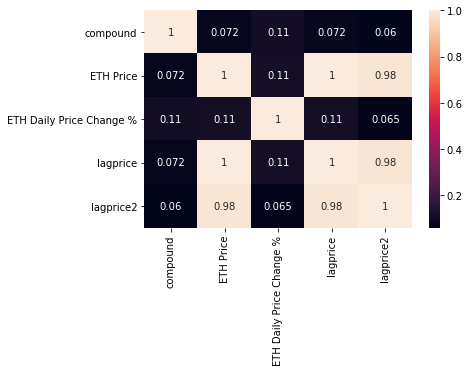

In [20]:
eth_heat_w = sns.heatmap(eth_corr_w.corr(), annot = True)
eth_hfig_w = eth_heat_w.get_figure()
eth_hfig_w.savefig('Plots/eth_heat_w.png')

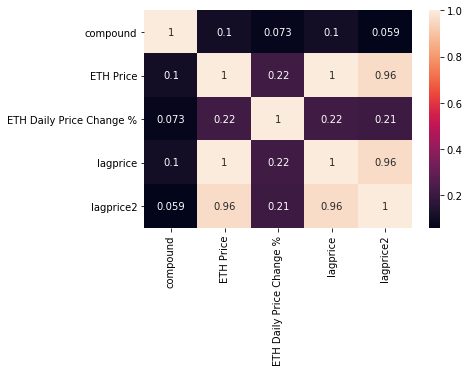

In [21]:
eth_heat_m = sns.heatmap(eth_corr_m.corr(), annot = True)
eth_hfig_m = eth_heat_m.get_figure()
eth_hfig_m.savefig('Plots/eth_heat_m.png')

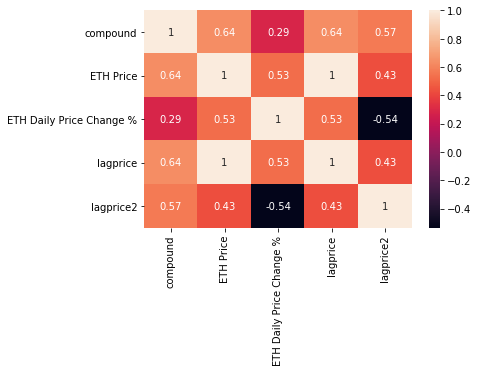

In [22]:
eth_heat_y = sns.heatmap(eth_corr_y.corr(), annot = True)
eth_hfig_y = eth_heat_y.get_figure()
eth_hfig_y.savefig('Plots/eth_heat_y.png')

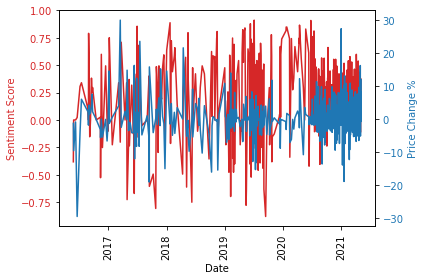

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(eth_viz_d['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(eth_viz_d['ETH Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

eth_lfig = ax2.get_figure()
eth_lfig.savefig('Plots/eth_lines_d.png')
plt.show()

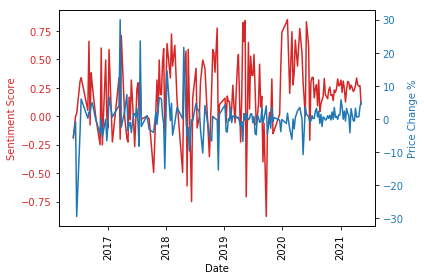

In [24]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(eth_viz_w['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(eth_viz_w['ETH Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

eth_lfig = ax2.get_figure()
eth_lfig.savefig('Plots/eth_lines_w.png')
plt.show()

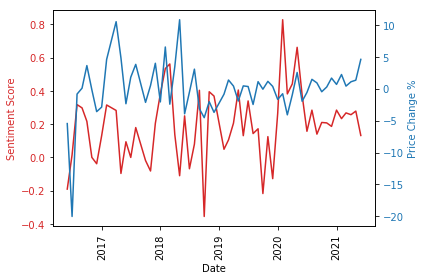

In [25]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(eth_viz_m['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(eth_viz_m['ETH Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

eth_lfig = ax2.get_figure()
eth_lfig.savefig('Plots/eth_lines_m.png')
plt.show()

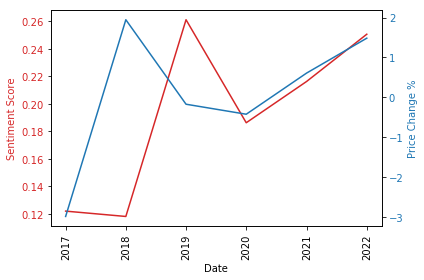

In [26]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(eth_viz_y['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(eth_viz_y['ETH Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

eth_lfig = ax2.get_figure()
eth_lfig.savefig('Plots/eth_lines_y.png')
plt.show()

## Build a predictive Model with Vader

In [27]:
# Add in a binary classifier for positive and negative price changes
eth_merged['target'] = np.where(eth_merged['ETH Daily Price Change %'] >= 0, 1, 0)

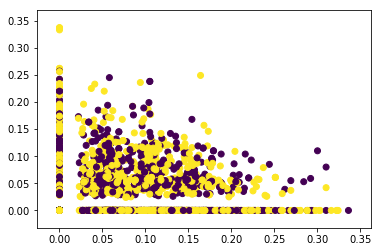

In [28]:
X = eth_merged["text"]
y = eth_merged["target"]

# Split data into train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# Visualize the data
eth_scatter = plt.scatter(eth_merged['positive'],eth_merged['negative'], c=y)
eth_sfig = eth_scatter.get_figure()
eth_sfig.savefig('Plots/eth_scatter.png')

In [29]:
# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [30]:
# Check dimensions
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['target'].value_counts()}\n")
print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['target'].value_counts())

Train: 1788 rows and 2 columns
1    1069
0     719
Name: target, dtype: int64

Test: 795 rows and 2 columns
1    455
0    340
Name: target, dtype: int64


In [31]:
train[['neg', 'neu', 'pos', 'compound']] = train['text'].apply(analyzer.polarity_scores).apply(pd.Series)
train.head()

,text,target,neg,neu,pos,compound
Date,,,,,,
2020-12-31,You can make use of the Binance Smart Chain-Et...,0,0.000,0.792,0.208,0.8176
2020-08-19,Ethereum failed to clear the $445 resistance a...,0,0.111,0.744,0.145,0.2263
2019-07-11,As crypto analysts pontificate that the so-cal...,0,0.000,1.000,0.000,0.0000
2020-09-14,The testnet – which is described as the “dress...,1,0.000,0.965,0.035,0.1280
2020-11-22,Investors expect the price of Ethereum to rise...,1,0.000,1.000,0.000,0.0000


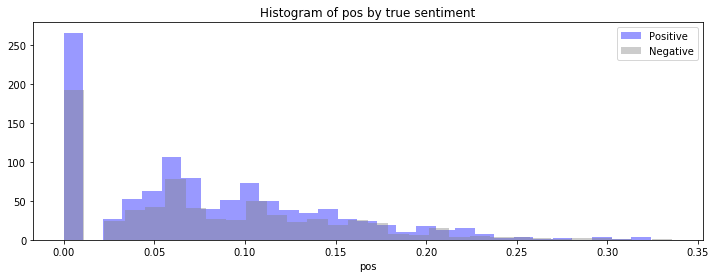

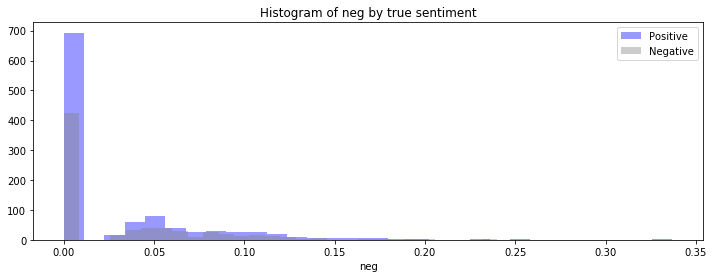

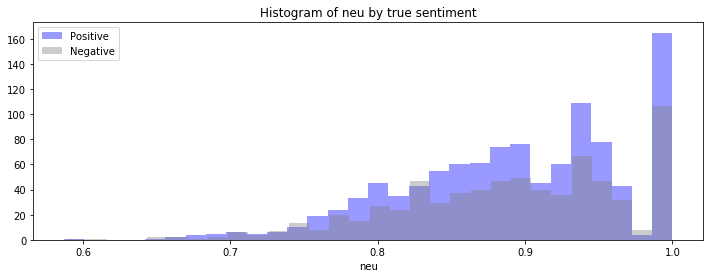

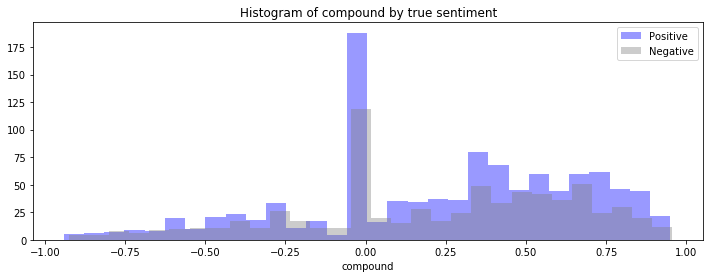

In [32]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='blue', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='gray', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment')
    plt.savefig("Plots/eth_"+str(var)+".png");

# Build a Predictive Model with RNN LSTM

In [33]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [34]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [35]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:10]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'the', token: 1
word: 'to', token: 2
word: 'a', token: 3
word: 'chars', token: 4
word: 'ethereum', token: 5
word: 'of', token: 6
word: 'and', token: 7
word: 'in', token: 8
word: 'is', token: 9
word: 'on', token: 10


In [36]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [37]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

**Text comment**
{'The scripting language in bitcoin is restricting application development, which is something that Ethereum can change, according to Fred Ehrsam, co-founder of Coinbase, which recently added Ethereum trading.\n\nEhrsam, writing in Medium, noted that in  ... [+11143 chars]'}


In [38]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[1, 6500, 1251, 8, 12, 9, 4436, 995, 397, 47, 9, 874, 14, 5, 99, 707, 66, 2, 4437, 4438, 227, 213, 6, 320, 47, 129, 708, 5, 52, 4438, 347, 8, 1721, 748, 14, 8, 6501, 4]


In [133]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the pad size
max_words = 10000

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq)
#                       , padding = 'post', truncating = 'post')
X_pad

array([[    0,     0,     0, ...,     8,  6501,     4],
       [    0,     0,     0, ...,  1722,  6503,     4],
       [    0,     0,     0, ...,   178,  6508,     4],
       ...,
       [    0,     0,     0, ...,  1285, 12443,     4],
       [    0,     0,     0, ...,    39, 12444,     4],
       [    0,     0,     0, ...,     1,  1904,    16]])

In [134]:
# Creating training, validation, and testing sets using the encoded data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [135]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler randomly duplicates minority class transactions
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_rnn, y_train_rnn)


In [136]:
len(y_test_rnn)

795

In [137]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [138]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

In [139]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [140]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [141]:
np.__version__

'1.19.5'

In [142]:
# Show model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10000, 64)         796672    
_________________________________________________________________
lstm_4 (LSTM)                (None, 280)               386400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 281       
Total params: 1,183,353
Trainable params: 1,183,353
Non-trainable params: 0
_________________________________________________________________


In [143]:
# Training the model
batch_size = 1000
epochs = 10
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/10
2/2 [==============================] - 18s 4s/step - loss: 0.6917 - accuracy: 0.5822 - tp: 847.0000 - tn: 44.0000 - fp: 585.3333 - fn: 49.0000 - precision: 0.5897 - recall: 0.9407 - auc: 0.5145 - val_loss: 0.6859 - val_accuracy: 0.6013 - val_tp: 359.0000 - val_tn: 0.0000e+00 - val_fp: 238.0000 - val_fn: 0.0000e+00 - val_precision: 0.6013 - val_recall: 1.0000 - val_auc: 0.5039
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.6846 - accuracy: 0.5907 - tp: 901.0000 - tn: 0.0000e+00 - fp: 624.3333 - fn: 0.0000e+00 - precision: 0.5907 - recall: 1.0000 - auc: 0.5480 - val_loss: 0.6749 - val_accuracy: 0.6013 - val_tp: 359.0000 - val_tn: 0.0000e+00 - val_fp: 238.0000 - val_fn: 0.0000e+00 - val_precision: 0.6013 - val_recall: 1.0000 - val_auc: 0.5173
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.6765 - accuracy: 0.5921 - tp: 902.3333 - tn: 0.0000e+00 - fp: 623.0000 - fn: 0.0000e+00 - precision: 0.5921 - recall: 1.0000 - auc: 0.6268 - val

In [144]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1000)


# Model Comparison
___

In [145]:
# Import relevant libraries from sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

### Classification Reports

In [146]:
#VADER - polarity model
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print("Classification Report for the VADER Sentiment Model using polarity scores")
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

Classification Report for the VADER Sentiment Model using polarity scores
              precision    recall  f1-score   support

    negative       0.42      0.38      0.40       719
    positive       0.61      0.65      0.63      1069

    accuracy                           0.54      1788
   macro avg       0.52      0.52      0.51      1788
weighted avg       0.53      0.54      0.54      1788



In [147]:
#VADER - compound model
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print("Classification Report for the VADER Sentiment Model using compound scores")
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

Classification Report for the VADER Sentiment Model using compound scores
              precision    recall  f1-score   support

    negative       0.42      0.38      0.40       719
    positive       0.61      0.64      0.63      1069

    accuracy                           0.54      1788
   macro avg       0.51      0.51      0.51      1788
weighted avg       0.53      0.54      0.53      1788



In [148]:
# Display classification report for the RNN LSTM Model
print("Classification Report for the RNN LSTM Model")
print(classification_report(y_rnn_pred, y_test_rnn))

Classification Report for the RNN LSTM Model
              precision    recall  f1-score   support

           0       0.07      0.73      0.12        30
           1       0.98      0.59      0.74       765

    accuracy                           0.59       795
   macro avg       0.52      0.66      0.43       795
weighted avg       0.95      0.59      0.71       795



### Confusion Matrices

In [149]:
# Create function we can call for all models
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

Confusion Matrix from the VADER model using polarity scores


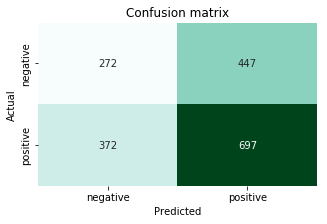

In [150]:
# Plot confusion matrix for VADER using polarity scores
print("Confusion Matrix from the VADER model using polarity scores")
plot_cm(train['target'], train['vader_polarity'])
plt.savefig('Plots/eth_pol_plot.png')

Confusion Matrix from the VADER model using compound scores


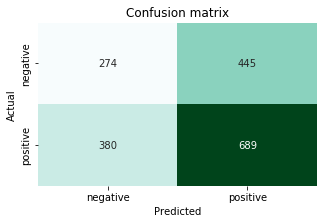

In [151]:
print("Confusion Matrix from the VADER model using compound scores")
plot_cm(train['target'], train['vader_compound'])
plt.savefig('Plots/eth_vcomp_plot.png')

Confusion Matrix from the RNN LSTM Model


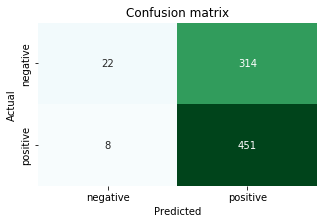

In [152]:
print("Confusion Matrix from the RNN LSTM Model")
plot_cm(y_test_rnn, y_rnn_pred)
plt.savefig('Plots/eth_lstm_plot.png')

### Accuracy Scores

In [153]:
print("Vader Accuracy - Polarity: %.2f" % (accuracy_score(train['target'], train['vader_polarity'])))
print("Vader Accuracy - Compound: %.2f" % (accuracy_score(train['target'], train['vader_compound'])))
print("RNN LSTM Accuracy %.2f" % (accuracy_score(y_test_rnn, y_rnn_pred)))

Vader Accuracy - Polarity: 0.54
Vader Accuracy - Compound: 0.54
RNN LSTM Accuracy 0.59


### AUC ROC

In [154]:
# Data for ROC Curve - VADER Compound
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(train['target'], train['vader_compound'])

In [155]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [156]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

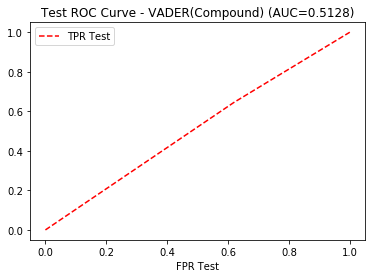

In [157]:
vcomp = roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - VADER(Compound) (AUC={auc_test_vader})",
)
eth_vcomp = vcomp.get_figure()
eth_vcomp.savefig('Plots/eth_vcomp.png')

In [158]:
# Data for ROC Curve - VADER Compound
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(train['target'], train['vader_polarity'])

In [159]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [160]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

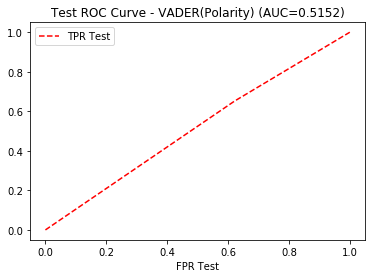

In [161]:
vpol = roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - VADER(Polarity) (AUC={auc_test_vader})",
)
eth_vpol = vpol.get_figure()
eth_vpol.savefig('Plots/eth_vpol.png')

In [162]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1000)

In [163]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

In [164]:
# AUC for the RNN LSTM Model
auc_test_rnn = auc(fpr_test_rnn, tpr_test_rnn)
auc_test_rnn = round(auc_test_rnn, 4)

In [165]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_rnn, "TPR Test": tpr_test_rnn,})

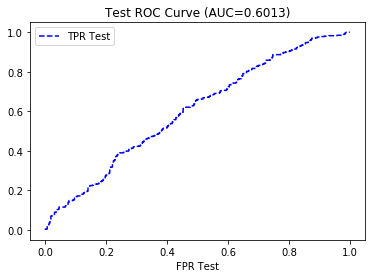

In [166]:
rnn = roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_rnn})",
)
eth_rnn = rnn.get_figure()
eth_rnn.savefig('Plots/eth_rnn.png')